## Faces recognition example using eigenfaces and SVMs

Authors: The scikit-learn developers

SPDX-License-Identifier: BSD-3-Clause


In [220]:
from time import time

import matplotlib.pyplot as plt
from scipy.stats import loguniform

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC  

import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder


In [221]:
# Dowload the dataset (we need a labeled faces)

# Configuración
image_dir = "./wicked_dataset"
image_size = (40, 40)  # Tamaño objetivo de las imágenes

# Cargar imágenes y etiquetas
def load_images(image_dir, image_size):
    X = []  # Imágenes
    y = []  # Etiquetas
    for person_name in os.listdir(image_dir):
        person_folder = os.path.join(image_dir, person_name)
        if os.path.isdir(person_folder):
            for file_name in os.listdir(person_folder):
                file_path = os.path.join(person_folder, file_name)
                try:
                    image = imread(file_path, as_gray=True)  # Cargar en escala de grises
                    image_resized = resize(image, image_size, anti_aliasing=True)
                    X.append(image_resized.flatten())  # Aplanar la imagen
                    y.append(person_name)  # Usar el nombre de la carpeta como etiqueta
                except Exception as e:
                    print(f"Error al procesar {file_path}: {e}")
    return np.array(X), np.array(y)

X, y = load_images(image_dir, image_size)

# Convertir etiquetas a números
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
target_names = label_encoder.classes_

print(f"Datos cargados: {X.shape[0]} imágenes de tamaño {X.shape[1]} píxeles")
print(f"Número de clases: {len(target_names)}")


Datos cargados: 12 imágenes de tamaño 1600 píxeles
Número de clases: 6


Split into a training set and a test and keep 25% of the data for testing.

In [222]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction / dimensionality reduction

In [230]:
n_components = 50

pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


ValueError: n_components=50 must be between 1 and min(n_samples, n_features)=9 with svd_solver='randomized'

Train a SVM classification model

In [224]:
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}

# cv es el numero de muestras que tiene cada clase
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=50, cv=2 
)
clf = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Best estimator found by grid search:
SVC(C=6406.835846750015, class_weight='balanced', gamma=0.0008829126534325726)


/home/elisa/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Quantitative evaluation of the model quality on the test set

In [225]:
# print("Predicting people's names on the test set")
# t0 = time()
# y_pred = clf.predict(X_test_pca)
# print("done in %0.3fs" % (time() - t0))

# print(classification_report(y_test, y_pred, target_names=target_names))
# ConfusionMatrixDisplay.from_estimator(
#     clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
# )
# plt.tight_layout()
# plt.show()

Qualitative evaluation of the predictions using matplotlib

In [226]:
def plot_gallery(images, titles, h, w, n_row=1, n_col=3):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(12, 8))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot the result of the prediction on a portion of the test set

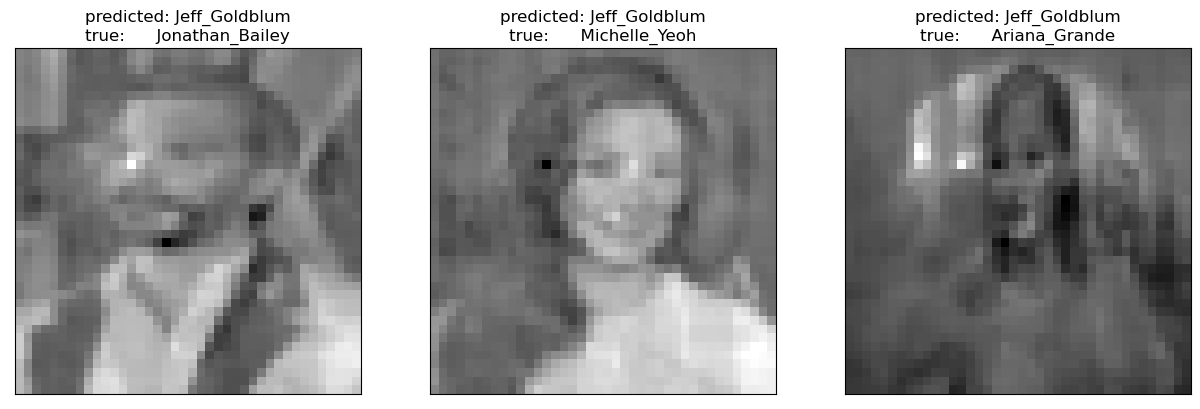

In [229]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return f"predicted: {pred_name}\ntrue:      {true_name}"

# Asegúrate de que 'y_pred' esté definido antes de este punto
y_pred = clf.predict(X_test_pca)  # Esto debe ejecutarse antes de mostrar las imágenes

# Generar los títulos para cada imagen
prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(len(y_pred))
]

# Mostrar la galería de imágenes
plot_gallery(X_test[:len(y_pred)], prediction_titles, 40, 40)